<img src="https://cybersecurity-excellence-awards.com/wp-content/uploads/2017/06/366812.png">

<h1><center>Darwin Normal Behavior Modeling (NBM) Example </center></h1>

# Prior to getting started:

Darwin notebook will no longer support 'Register User' starting from 2.0. As a user, you must have credentials ready before using this notebook. 

In order to proceed, in the Environment Variables cell: 
1. Set your username and password to ensure that you're able to log in successfully
2. Set the path to the location of your datasets if you are using your own data.  The path is set for the examples.

Here are a few things to be mindful of:
1. For every run, check the job status (i.e. requested, failed, running, completed) and wait for job to complete before proceeding. 
2. If you're not satisfied with your model and think that Darwin can do better by exploring a larger search space, use the resume function.

## Import necessary libraries

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import datetime
from sklearn.metrics import r2_score
from amb_sdk.sdk import DarwinSdk
from IPython.display import Image
from time import sleep

## Set Darwin SDK

In [48]:
ds = DarwinSdk()
ds.set_url('https://darwin-api.sparkcognition.com/v1/')

(True, 'https://amb-api.sparkcognition.com/v1/')

## Environment Variables

In [ ]:
#Set your user id and password accordingly
USER="[your Darwin user id]"
PW="[your Darwin password]"

# Set path to datasets - The default below assumes Jupyter was started from amb-sdk/examples/Enterprise/
# Modify accordingly if you wish to use your own data
PATH_TO_DATASET = '../../sets/'
TRAIN_DATASET = 'wind_turbine.csv'

# A timestamp is used to create a unique name in the event you execute the workflow multiple times or with 
# different datasets.  File names must be unique in Darwin.
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

# User Login

In [6]:
status, msg = ds.auth_login_user(USER,PW)
if not status:
    print(msg)
else:
    print("Login successfully!")

Login successfully!


# Data Upload

**Read dataset and view a file snippet**
<br>After setting up the dataset path, the next step is to upload the dataset from your local device to the server.

In [20]:
# Preview dataset
df = pd.read_csv(os.path.join(PATH_TO_DATASET, TRAIN_DATASET))
df.tail()

,timestamp,YAWDIRDEG,TMPCTRLTOPDEGC,VCNV,XFMRTMPPHADEGC,P10MACTKW,GENTMPPHCDEGC,FREQHZ,BRGTMPGENNDEDEGC,GENTMPSLIPDEGC,...,WSMPS,HYDRTMPDEGC,BRGTMPGBXADEGC,BLDANGDEG,AMBTMPDEGC,ICA,PSETKW,GENTMPPHBDEGC,PEXPKW,TMPCTRLHUBDEGC
51401,8/23/15 23:10,1000.0,35.0,408.8,48.0,-1.6,26.0,60.00,26.0,999.0,...,1.8,35.0,29.0,86.0,22.0,0.4,0.0,26.0,0.0,26.0
51402,8/23/15 23:20,1000.0,35.0,409.1,48.0,-1.6,26.0,60.00,26.0,999.0,...,1.7,35.0,29.0,86.0,22.0,0.4,0.0,26.0,0.0,25.0
51403,8/23/15 23:30,1000.0,35.0,408.1,49.0,-1.5,26.0,60.00,26.0,999.0,...,1.5,35.0,29.0,86.0,22.0,0.3,0.0,26.0,0.0,25.0
51404,8/23/15 23:40,1000.0,35.0,407.9,49.0,-1.6,26.0,60.00,26.0,999.0,...,1.6,35.0,29.0,86.0,22.0,0.4,0.0,26.0,0.0,25.0
51405,8/23/15 23:50,1000.0,35.0,407.6,49.0,-1.5,26.0,60.02,26.0,999.0,...,2.1,35.0,29.0,86.0,22.0,0.3,0.0,26.0,0.0,25.0


**Upload dataset to Darwin**

In [8]:
# Upload dataset
status, dataset = ds.upload_dataset(os.path.join(PATH_TO_DATASET, TRAIN_DATASET))
print(status)
print(dataset)

if not status:
    print(dataset)
else:
    print("Upload successfully!")

True
{'dataset_name': 'SmokyT025_full_raw.csv'}
Upload successfully!


## Analyze Data
Analyze data is a necessary step before cleaning data and creating model. 

In [9]:
status, analyze_id = ds.analyze_data(TRAIN_DATASET, 
                                     job_name = 'Darwin_analyze_data_job' + "-" + ts, 
                                     artifact_name = 'Darwin_analyze_data_artifact' + "-" + ts)
sleep(1)
if status:
    ds.wait_for_job('Darwin_analyze_data_job' + "-" + ts)
else:
    print(analyze_id)

{'status': 'Complete', 'starttime': '2019-07-17T16:20:32.264496', 'endtime': None, 'percent_complete': 100, 'job_type': 'AnalyzeData', 'loss': None, 'generations': None, 'dataset_names': ['SmokyT025_full_raw.csv'], 'artifact_names': ['Darwin_analyze_data_artifact-20190717161916'], 'model_name': None, 'job_error': None}


## **Clean dataset**

In [27]:
# clean dataset
status, job_id = ds.clean_data(TRAIN_DATASET, index='timestamp')

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Complete', 'starttime': '2019-07-17T16:29:27.005176', 'endtime': None, 'percent_complete': 100, 'job_type': 'CleanData', 'loss': None, 'generations': None, 'dataset_names': ['SmokyT025_full_raw.csv'], 'artifact_names': None, 'model_name': None, 'job_error': None}


# Create and Train Model 

We will now build a model that will learn the normal behavior of an asset based on a failure date.<br> The failure date in our example dataset is 8/24/15. <br> You will have to specify a different failure date for your custom dataset. <br> You can also specify a recovery_dates when the asset comes back online.


In [28]:
model = "model103" + "-" + ts
status, job_id = ds.create_model(dataset_names = TRAIN_DATASET, 
                                 failure_dates = ['08/23/15'], 
                                 model_name =  model, 
                                 nbm = True, 
                                 max_train_time = '00:01',
                                 recurrent = False,
                                 fit_profile_name = job_id['profile_name'])
if status:
    ds.wait_for_job(job_id['job_name'], time_limit=720)
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-07-17T16:29:42.748509', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['SmokyT025_full_raw.csv'], 'artifact_names': None, 'model_name': 'model103-20190717161916', 'job_error': None}
{'status': 'Running', 'starttime': '2019-07-17T16:29:42.748509', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['SmokyT025_full_raw.csv'], 'artifact_names': None, 'model_name': 'model103-20190717161916', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-17T16:29:42.748509', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['SmokyT025_full_raw.csv'], 'artifact_names': None, 'model_name': 'model103-20190717161916', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-17T16:29:42.748509', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainMod

## Extra Training (Optional)
Run the following cell for extra training, no need to specify parameters

In [29]:
# Train some more
status, job_id = ds.resume_training_model(dataset_names = TRAIN_DATASET,
                                          model_name = model,
                                          max_train_time = '00:01')
                                          
if status:
    ds.wait_for_job(job_id['job_name'], time_limit=720)
else:
    print(job_id)

{'status': 'Running', 'starttime': '2019-07-17T16:31:32.908941', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.1257348135816601, 'generations': 1, 'dataset_names': ['SmokyT025_full_raw.csv'], 'artifact_names': None, 'model_name': 'model103-20190717161916', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-17T16:31:32.908941', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.1257348135816601, 'generations': 1, 'dataset_names': ['SmokyT025_full_raw.csv'], 'artifact_names': None, 'model_name': 'model103-20190717161916', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-17T16:31:32.908941', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.1257348135816601, 'generations': 1, 'dataset_names': ['SmokyT025_full_raw.csv'], 'artifact_names': None, 'model_name': 'model103-20190717161916', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-17T16:31:32.908941', 'endtime': None, 'pe

## Analyze Model
Analyze model provides feature importance ranked by the model. <br> It indicates a general view of which features pose a bigger impact on the model

In [31]:
# Retrieve feature importance of built model
#status, artifact = ds.analyze_model(model)
status, analyze_id = ds.analyze_model(job_id['model_name'], 
                                      job_name='Darwin_analyze_model_job-' + ts, 
                                      artifact_name='Darwin_analyze_model_artifact-' + ts)
sleep(1)
if status:
    ds.wait_for_job(analyze_id['job_name'])
else:
    print(analyze_id)
status, feature_importance = ds.download_artifact(analyze_id['artifact_name'])

400: BAD REQUEST - {"message": "A job with this name already exists"}



TypeError: string indices must be integers

In [ ]:
status, feature_importance = ds.download_artifact(analyze_id['artifact_name'])

In [ ]:
feature_importance[:10]

## Predictions
**Perform model prediction on the the training dataset.**

In [33]:
status, dataset = ds.upload_dataset(os.path.join(PATH_TO_DATASET, TEST_DATASET))
if not status:
    print(dataset)
else:
    print("Upload data successfully!")

Upload data successfully!


In [34]:
# clean test dataset
status, job_id = ds.clean_data(TEST_DATASET, model_name = model)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Complete', 'starttime': '2019-07-17T16:34:52.312005', 'endtime': None, 'percent_complete': 100, 'job_type': 'CleanData', 'loss': None, 'generations': None, 'dataset_names': ['SmokyT025_test_raw.csv'], 'artifact_names': None, 'model_name': None, 'job_error': None}


In [35]:
status, artifact = ds.run_model(TEST_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-07-17T16:35:06.389628', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.1257348135816601, 'generations': 2, 'dataset_names': ['SmokyT025_test_raw.csv'], 'artifact_names': ['4fe64553f4194e178d382dd8da115b2f'], 'model_name': 'model103-20190717161916', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-07-17T16:35:06.389628', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.1257348135816601, 'generations': 2, 'dataset_names': ['SmokyT025_test_raw.csv'], 'artifact_names': ['4fe64553f4194e178d382dd8da115b2f'], 'model_name': 'model103-20190717161916', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-07-17T16:35:06.389628', 'endtime': '2019-07-17T16:35:23.154563', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.1257348135816601, 'generations': 2, 'dataset_names': ['SmokyT025_test_raw.csv'], 'artifact_names': ['4fe64553f4194e178d382dd8da115b2f'], 'model_name': 'model103-20190

(True, 'Job completed')

**Download predictions from Darwin's server.**

In [36]:
status, prediction = ds.download_artifact(artifact['artifact_name'])

Create plots showing the risk index prediction of the model

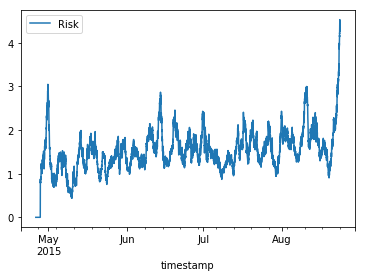

In [45]:
#Plot the risk predictions
df = pd.read_csv(os.path.join(PATH_TO_DATASET, TEST_DATASET))
prediction.set_index(pd.to_datetime(df['timestamp']), inplace=True)
prediction.plot()

## Find out which machine learning model did Darwin use:

In [46]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

[{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 10}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'identity', 'numunits': 37}}}]
